# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Nihal Ezgi Yücetürk"
student2 = "Atakan Büyükoğlu"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [112]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2
from keras.initializers import RandomNormal

### Plotting

In [23]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', #deleted +1 after label_mapping[j]
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

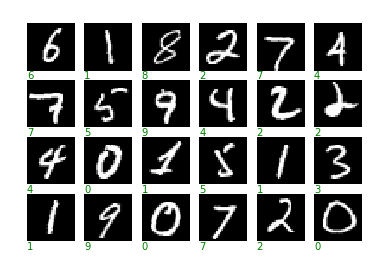

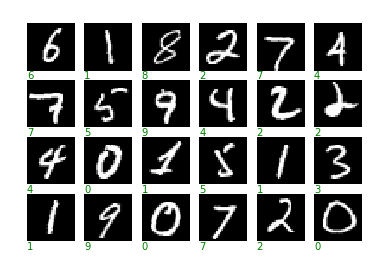

In [24]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

plot_some_samples(x_train, y_train)

Answer to question 2:
Numbers in green idicate the image labels

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [27]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [28]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [29]:
x_train[0].shape

(784,)

In [13]:
num_classes = 10
in_shape = x_train[0].shape
batch_size = 128
epochs = 50

In [120]:
from keras.callbacks import Callback

class stopAtLossValue(Callback):
        #prev_loss = np.Infinity
        prev_acc = 0
        def on_epoch_end(self, epoch, logs={}):
            eps = 0.01 
            #loss = logs.get('loss')
            acc  = logs.get('val_acc')
            if (self.prev_acc - acc) >= eps:
                self.model.stop_training = True
                self.prev_acc = 0
            else:
                self.prev_acc = acc

model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=in_shape))
#model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [122]:
callbacks = [
    stopAtLossValue(),
]

In [40]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = callbacks, validation_split = 0.15 )


Train on 51000 samples, validate on 9000 samples
Epoch 1/50
51000/51000 [==============================] - 1s 20us/step - loss: 1.3239 - acc: 0.6860 - val_loss: 0.8379 - val_acc: 0.8434
Epoch 2/50
51000/51000 [==============================] - 1s 18us/step - loss: 0.7648 - acc: 0.8316 - val_loss: 0.6163 - val_acc: 0.8707
Epoch 3/50
51000/51000 [==============================] - 1s 18us/step - loss: 0.6255 - acc: 0.8524 - val_loss: 0.5271 - val_acc: 0.8790
Epoch 4/50
51000/51000 [==============================] - 1s 18us/step - loss: 0.5580 - acc: 0.8632 - val_loss: 0.4775 - val_acc: 0.8862
Epoch 5/50
51000/51000 [==============================] - 1s 18us/step - loss: 0.5166 - acc: 0.8696 - val_loss: 0.4459 - val_acc: 0.8909
Epoch 6/50
51000/51000 [==============================] - 1s 18us/step - loss: 0.4881 - acc: 0.8747 - val_loss: 0.4232 - val_acc: 0.8939
Epoch 7/50
51000/51000 [==============================] - 1s 22us/step - loss: 0.4669 - acc: 0.8787 - val_loss: 0.4061 - val_acc:

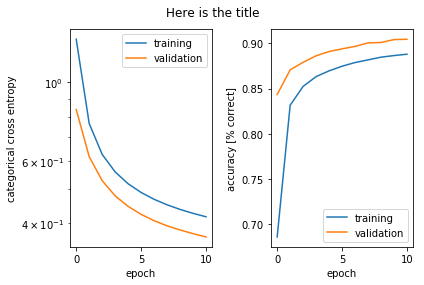

In [41]:
plot_history(history, "Here is the title");

In [42]:
def misclassed_incides():
    pred_y = model.predict_classes(x_test)
    y_orig = np.argmax(y_test, axis=1)
    if len(pred_y)!= len(y_orig):
        raise ValueError('LEnght mismatch')
    err = np.nonzero(pred_y - y_orig)[0]
    plot_some_samples(x_test, y_orig, pred_y, select_from=err)

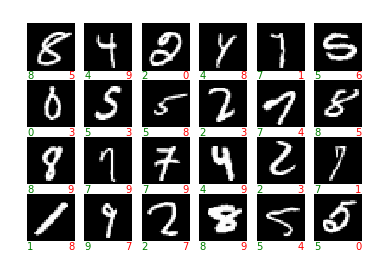

In [43]:
misclassed_incides()

Answer to question 10: Green ones are the true lables of the data points whereas the red ones are what our model predicted for the corresponding data point

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [76]:
# Part 1
def model_Q3():
    # Create the model
    model = Sequential()

    # Add the layers
    model.add(Dense(128, activation='relu', input_shape=in_shape))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model_Q3().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [71]:
lr_list = np.arange(0.01,0.11,0.01)
batch_size = 128
epochs = 50

In [55]:
# Part 2
sgd_acc_list = []
model = model_Q3()
for lr_ in lr_list:
# Add the learnig rate parameter to the model
    sgd = SGD(lr=lr_)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


# Fit the model
    history_sgd = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks = callbacks, validation_data = (x_test, y_test) )
    
    sgd_acc_list.append(history_sgd.history['acc'][-1])


In [72]:
lr_chosen = lr_list[np.argmax(sgd_acc_list)]
lr_chosen

0.04

In [78]:
sgd = SGD(lr=lr_chosen)
model = model_Q3()
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


# Fit the model
history_sgd = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = None, validation_data = (x_test, y_test) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.6342 - acc: 0.8385 - val_loss: 0.3593 - val_acc: 0.8991
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3398 - acc: 0.9047 - val_loss: 0.2980 - val_acc: 0.9174
Epoch 3/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.2916 - acc: 0.9179 - val_loss: 0.2637 - val_acc: 0.9242
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2613 - acc: 0.9265 - val_loss: 0.2386 - val_acc: 0.9327
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.2379 - acc: 0.9335 - val_loss: 0.2199 - val_acc: 0.9380
Epoch 6/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.2191 - acc: 0.9387 - val_loss: 0.2062 - val_acc: 0.9420
Epoch 7/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.2033 - acc: 0.9434 - val_loss: 0.1927 - val_acc

In [79]:
adm = Adam(lr=lr_chosen)
model = model_Q3()
model.compile(loss='categorical_crossentropy',
              optimizer=adm,
              metrics=['accuracy'])


# Fit the model
history_adam = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = None, validation_data = (x_test, y_test) )


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.3821 - acc: 0.9004 - val_loss: 0.2188 - val_acc: 0.9384
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2445 - acc: 0.9331 - val_loss: 0.2408 - val_acc: 0.9345
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.2300 - acc: 0.9400 - val_loss: 0.2298 - val_acc: 0.9457
Epoch 4/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.2257 - acc: 0.9429 - val_loss: 0.2815 - val_acc: 0.9375
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.2338 - acc: 0.9432 - val_loss: 0.2942 - val_acc: 0.9380
Epoch 6/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2354 - acc: 0.9449 - val_loss: 0.2667 - val_acc: 0.9432
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.2190 - acc: 0.9473 - val_loss: 0.2703 - val_acc

In [92]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training' )
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax1.legend(loc='lower left')
    
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    ax2.legend(loc='lower left')
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

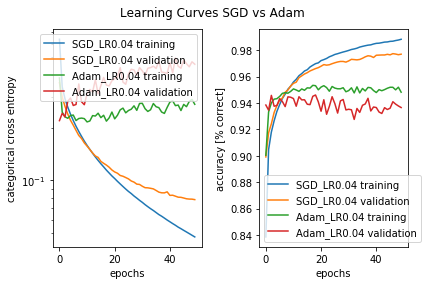

In [93]:
comparison_plot(history_sgd, history_adam, 'SGD_LR'+str(lr_chosen), 'Adam_LR'+str(lr_chosen), 'Learning Curves SGD vs Adam' );

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A)It overshoots the minimum of the error function and loss starts to increase after some epochs.

B)It takes very long time (too much epochs) for SGD to converge the minimum of the error curve.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: It starts overfitting apporoximately in 15th epoch; after 20 more reliably.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: For loss curves, training loss approaches to zero when number of epochs increases so does validation loss but validation loss starts to increase again when overfitting begins. For accuracy curves, both increases until overfitting begins. Training accuracy approaches to 100 while validation accuracy stays stable or decreases.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [106]:
# Part 1

#The number of neurons in the hidden layers
neuron_counts = [10, 100, 250, 500, 1000]
adm = Adam(lr= 0.001)
batch_size = 128
epochs = 15



#Keep history for the next part
histories = []

# Fit the model for different hidden neuron counts
for num_hidden in neuron_counts:
    
    # Create the model
    model = Sequential()

    # Add the layers
    model.add(Dense(num_hidden, activation='relu', input_shape=in_shape))
    model.add(Dense(num_classes, activation='softmax'))

    # Add the optimization parameters to the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=adm,
                  metrics=['accuracy'])
    
    # Model summary
    model.summary()
    # Fit the model
    
    histories.append( model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = callbacks, validation_data = (x_test, y_test) )
                    )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_56 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 68us/step - loss: 0.7812 - acc: 0.7752 - val_loss: 0.3982 - val_acc: 0.8899
Epoch 2/15
60000/60000 [==============================] - 2s 25us/step - loss: 0.3637 - acc: 0.8950 - val_loss: 0.3222 - val_acc: 0.9095
Epoch 3/15
60000/60000 [==============================] - 2s 25us/step - loss: 0.3148 - acc: 0.9100 - val_loss: 0.2944 - val_acc: 0.9163
Epoch 4/15
60000/60000 [==============================] - 2s 25us/step - lo

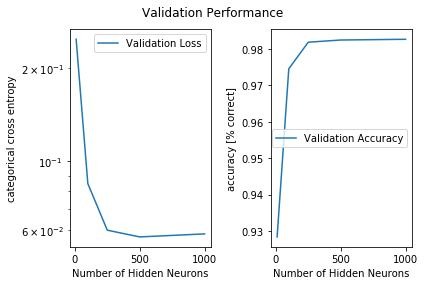

In [107]:
# Part 2

# Variables to hold validation loss and accuracy maximums
val_loss_max = []
val_acc_max = []

for history in histories:
    val_loss_max.append(min(history.history['val_loss']))
    val_acc_max.append(max(history.history['val_acc']))
    
# Plot the results
fig, ax1, ax2 = prepare_standardplot('Validation Performance', 'Number of Hidden Neurons')
ax1.plot(neuron_counts, val_loss_max, label = "Validation Loss")
ax2.plot(neuron_counts, val_acc_max, label = "Validation Accuracy")
#ax1.set_xscale('log')
#ax2.set_xscale('log')
finalize_standardplot(fig, ax1, ax2)

In [ ]:
# Part 3

Answer to question 2:

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [116]:
adm = Adam(lr = 0.001)
num_classes = 10
in_shape = x_fashion_train[0].shape
batch_size = 128
epochs = 100

In [117]:
drop_out = [False, True]
batch_norm = [False, True]
l2_reg= [False, True]

In [ ]:
histories = []
for dr in drop_out:
    for bn in batch_norm:
        for l_2 in l2_reg:
                # Create the model
                model = Sequential()
                if l_2:
                    if bn:
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l2()))
                        model.add(BatchNormalization())
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(), 
                                    kernel_regularizer = l2()))
                        model.add(BatchNormalization())
                    else :
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l2()))
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(), 
                                    kernel_regularizer = l2()))
                else:
                    if bn:
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))
                        model.add(BatchNormalization())
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))
                        model.add(BatchNormalization())
                    else:
                        model.add(Dense(50, activation='relu', input_shape=in_shape, bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))
                        model.add(Dense(50, activation='relu', bias_initializer = RandomNormal(),
                                   kernel_regularizer = l1()))            
                
                if dr:
                    model.add(Dropout(0.5))
                
                model.add(Dense(num_classes, activation='softmax'))

                # Add the optimization parameters to the model
                model.compile(loss='categorical_crossentropy',
                      optimizer=adm,
                      metrics=['accuracy'])
                
                hist = model.fit(x_fashion_train,y_fashion_train,
                          batch_size=batch_size,
                          epochs=epochs,
                        verbose=1,
                        callbacks = callbacks, validation_data = (x_fashion_test, y_fashion_test) )
                    
                histories.append(hist)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 124us/step - loss: 1.9858 - acc: 0.7031 - val_loss: 1.2841 - val_acc: 0.7287
Epoch 2/100
60000/60000 [==============================] - 2s 35us/step - loss: 1.2036 - acc: 0.7456 - val_loss: 1.1686 - val_acc: 0.7476
Epoch 3/100
60000/60000 [==============================] - 2s 35us/step - loss: 1.1358 - acc: 0.7543 - val_loss: 1.1215 - val_acc: 0.7522
Epoch 4/100
60000/60000 [==============================] - 2s 36us/step - loss: 1.0968 - acc: 0.7599 - val_loss: 1.1182 - val_acc: 0.7542
Epoch 5/100
60000/60000 [==============================] - 2s 38us/step - loss: 1.0672 - acc: 0.7649 - val_loss: 1.0548 - val_acc: 0.7660
Epoch 6/100
60000/60000 [==============================] - 2s 37us/step - loss: 1.0393 - acc: 0.7655 - val_loss: 1.0437 - val_acc: 0.7659
Epoch 7/100
60000/60000 [==============================] - 2s 37us/step - loss: 1.0187 - acc: 0.7691 - val_loss: 1.0281 -

Answer to question 2 (comments):

In [ ]:
model.fit()

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Answer to question 1:

Answer to question 2: